# Session 3: Tensors and Back-propagation


In [1]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from visualize import visualize2d
import scipy
%matplotlib inline

## 3.1 Introduction

### Back-propagation: sending information through Graphs
In order to efficiently compute the gradient on large neural networks, all neural network frameworks construct what is referred to as a **Graph**. This Graph retains the order of operation applied to every input by storing the intermediate values and operations performed at every step. This way when the output error is computed, it can be propagated backwards through the Graph. Applying Gradient Descent with those computed gradients will nudge the weights in a better state. An example is given below
<img src="images/bp1.png">

In vectorial form:
<img src="images/bp1a.png">

We can also augment the number of outputs:
<img src="images/bp2.png">

And write that in vectorial form:
<img src="images/bp2a.png">

Every operation in a Neural Network can be approximated by a group of nodes that take either 1 or 2 inputs and produce 1 output. Thanks to the chain rule, every node in this graph can be looked at independantly. Thus to compute the gradient of the inputs, all that is needed is the gradient of the output, the value of the inputs and the inverse of the applied function. Thanks to this *divide and conquer approach*, a large and complex system, like a deep neural network, is split up in small manageable parts.

### Tensors
In the mathematical sense a Tensor is a multi-dimensional array. Some special cases are the vector (1D) and matrix (2D). In Deep Learning this term refers to a data-array whose dimensions will depend on the situation (due to the varying batch-sizes). During this practical session we'll focus on the 'simpler' Fully Connected layers, thus only 1D and 2D Tensors will be used. In a few weeks we'll expand this to 4D Tensors in order to support Convolutional layers.

### Auto-grad systems
There are 2 ways to code Back-Propagation. You could for every possible operation in a Neural Network define a module and compute the gradients by hand for every operation:
```
class TestModule():
    def __init__(self, param1, param2):
        self.param1 = param1
        self.param2 = param2
        self.weights = <matrix>(param1, param2)
    
    def forward(self, x1, x2):
        self.x1 = x1
        self.x2 = x2
        # f computes a function
        return f(self.weights, x1, x2)
    
    def backwards(self):
        # df computes the gradients for weights, x1 and x2 based on 
        # the partial derivative of f
        return df(self.weights, self.x1, self.x2)
```
While there is nothing wrong with this approach it isn't really that handy to use since every module will need it's own forward and backward steps. Wouldn't it be great if we could do something like this
```
x1 = GradTensor(<data1>)
x2 = GradTensor(<data2>)
y = x1+x2
z = (y*x1)+5
```
and have the gradients be computed automatically along the way? 

## 3.2 First objective

The point today will be to implement a somewhat simplified **autograd system** from scratch. Such a system constructs a Graph and automatically computes the gradients based on this structure. Thus during the forward pass *dependencies* are created in order to remember the data-flow and *gradients in the form of lambda-functions* are saved. This is done because **the gradient at the start of the network can only be computed once every subsequent gradient already has been computed**!

We provide you the main structure and ask you to fill in the following functions:
* `gt_add`: Matrix addition (this one will be done by the assistant as an example)
* `gt_mul`: Elementwise matrix multiplication
* `gt_matmul`: Matrix multiplication 

In both cases you may suppose that the matrices have the *correct dimension*. Thus if you encounter a dimension problem, *your* code is at fault. To test your implementation execute the cell below, if no errors occur you can move on.

Dont worry about the following 2 functions `GradTensor._add_batch_dim` and `gt_type_check`. Those functions are there to avoid errors caused by `numpy` [broadcasting](https://numpy.org/devdocs/user/theory.broadcasting.html).

In [2]:
class GradTensor():
    def __init__(self, data, dependencies=None, requires_grad=True, requires_update=False):
        """ This object contains data in the form of a numpy array, but also saves its 
            gradients while computations are made
        
        Args:
            data: initialized numpy.ndarray
            dependencies:  Iterable containing GradTensors directly upstream in the computation
                           Graph. Thus their gradient can only be computed once the gradient
                           of @self has been computed
            requires_grad: Does this object need a gradient
            require_update: Is this tensor a parameter that will need updates:
                            if True:   this GradTensor is a parameter/weight
                            otherwise: this GradTensor is either an input or intermediate value
        """
        assert hasattr(data, "shape"), "Data needs to be numpy array"
        assert len(data.shape) <= 2, "Tensors of 2 dimensions max are supported"
        assert dependencies is None or len(dependencies) <= 2, "Backpropagation nodes should have 2 inputs at best!"
        
        self.data = data
        self.orig_shape = data.shape
        
        self.requires_grad = requires_grad
        self.requires_update = requires_update
        self.dependencies = dependencies or ()
        
        self.grad = 0  # Contains the value of the gradient
        self.grad_fx = lambda: None  # Will contain a lambda function that will return the gradient
    
    @property
    def shape(self):
        return self.data.shape

    def add_grad(self, df):
        """ Sets the gradient computation function
        
        Args:
            df: lambda function that returns the gradient value to be added
        """
        if self.requires_grad:
            self.grad_fx = df
    
    def backward(self, **kwargs):
        """ Computes the backward pass recursively and applies the computed gradient on elements of the graph
            if they have requieres_update set to True. Can only be called on a singular value
        """
        assert self.shape == (), "Backward should only be called on single value not matrix or vector"
        self.grad_fx = lambda: 1.0
        self._backward(**kwargs)        

    def _backward(self, **kwargs):
        if self.requires_grad:
            self.grad = self.grad_fx()
            for dep in self.dependencies:
                dep._backward(**kwargs)
            self.step(**kwargs)
    
    def step(self, lr=0.1, **kwargs):
        if self.requires_update:               
            self.data = self.data - lr*self.grad
            if self.shape != self.orig_shape:
                raise ValueError(f"Shape shouldn't change {self.shape}, {self.orig_shape}")
            self.zero_grad()
    
    def zero_grad(self):
        self.grad = 0
        
    def __str__(self):
        return f"GradTensor(data:\n{self.data}\nshape:{self.shape})"
    
    def _add_batch_dim(self, n_repeat):
        # Adds a dimension to handle numpy broadcasting during backprop
        expanded = GradTensor(np.tile(self.data, (n_repeat, 1)), dependencies=(self,))
        self.add_grad(lambda: np.sum(expanded.grad, axis=0))
        return expanded
    
    @property
    def T(self):
        return gt_transpose(self)
    
    def __mul__(self, other):  # Overrides * operator
        return gt_mul(self, other)
    __rmul__ = __mul__

    def __add__(self, other):  # Overrides + operator
        return gt_add(self, other)
    __radd__ = __add__

    def __sub__(self, other):  # Overrides - operator
        return gt_sub(self, other)

    def __rsub__(self, other):
        return gt_sub(other, self)

    def __matmul__(self, other):  # Overrides @ operator
        return gt_matmul(self, other)
    
    def mean(self):
        return gt_mean(self)
    
    def abs(self):
        return gt_abs(self)
    
    def relu(self):
        return gt_relu(self)


def gt_type_check(dim_check=False): # DO NOT TRY TO UNDERSTAND THIS
    def _type_checker(f):
        def type_checker(*args):
            ok_args = []
            for i, x in enumerate(args):
                if type(x) != GradTensor:
                    ok_args.append(GradTensor(x*np.ones_like(args[i-1].data), requires_grad=False))
                else:
                    ok_args.append(x)
            _ok_args = ok_args
            if dim_check and ok_args[0].shape!=ok_args[1].shape:
                batch_size = ok_args[1].shape[0] if len(ok_args[0].shape)==1 else ok_args[0].shape[0]
                _ok_args = []
                for i, x in enumerate(ok_args):
                    if len(x.shape) > 1:
                        _ok_args.append(x)
                    else:
                        _ok_args.append(x._add_batch_dim(batch_size))
                    
            return f(*_ok_args)
        return type_checker
    return _type_checker
        

@gt_type_check()
def gt_transpose(x):
    z = GradTensor(x.data.T, dependencies=(x,))
    x.add_grad(lambda: z.grad.T)
    return z

@gt_type_check()
def gt_mean(x):
    z = GradTensor(np.mean(x.data), dependencies=(x,))
    x.add_grad(lambda: z.grad/np.prod(x.shape)*np.ones_like(x.data))
    return z

@gt_type_check()
def gt_abs(x):
    z = GradTensor(np.abs(x.data), dependencies=(x,))
    x.add_grad(lambda: np.where(x.data>0, z.grad, -z.grad))
    return z

@gt_type_check()
def gt_relu(x):
    z = GradTensor(np.clip(x.data, 0, None), dependencies=(x,))
    x.add_grad(lambda: np.where(x.data>0, z.grad, 0))
    return z


@gt_type_check()
def gt_matmul(x, y):
    z = GradTensor(x.data @ y.data, dependencies=(x,y))
    x.add_grad(lambda: z.grad   @ y.data.T)
    y.add_grad(lambda: (z.grad.T @ x.data).T)
    return z

@gt_type_check(True)
def gt_add(x, y):
    z = GradTensor(x.data + y.data, dependencies=(x,y))
    x.add_grad(lambda: z.grad)  # = dz/dx * dL/dz
    y.add_grad(lambda: z.grad)  # = dz/dw * dL/dz
    return z

@gt_type_check(True)
def gt_sub(x, y):
    z = GradTensor(x.data - y.data, dependencies=(x,y))
    x.add_grad(lambda:  z.grad)  # = dz/dx * dL/dz
    y.add_grad(lambda: -z.grad)  # = dz/dw * dL/dz
    return z

@gt_type_check(True)
def gt_mul(x, y):
    z = GradTensor(x.data * y.data, dependencies=(x,y))
    x.add_grad(lambda: y.data * z.grad)  # = dz/dx * dL/dz
    y.add_grad(lambda: x.data * z.grad)  # = dz/dw * dL/dz
    return z

**Test functions for the GradTensor**

**Execute** the code below to check your implementation

In [3]:
def one_layer(bias=False):
    w = torch.rand(10,5)-0.5
    b = torch.rand(10)*2-1
    x = torch.rand(2,5)
    ytrue = torch.rand(2,10)

    lin = nn.Linear(5,10, bias=bias)
    with torch.no_grad():   
        lin.weight[:] = w
        if bias:
            lin.bias[:] = b
    z = lin(x)
    loss = torch.mean(torch.abs(z-ytrue.float()))  # L1-loss
    loss.backward()  # Computes the gradients
    
    gw = GradTensor(w.numpy())
    gb = GradTensor(b.numpy())
    gx = GradTensor(x.numpy())
    gytrue = GradTensor(ytrue.numpy())
    gz = gx @ gw.T
    if bias:
        gz = gz + gb
    gloss = (gz-gytrue)
    gloss = gloss.abs().mean()
    gloss.backward()

    assert np.abs(loss.detach().numpy() - np.sum(gloss.data)) < 1e-6, "The forward pass is incorrect"
    assert np.abs(lin.weight.grad.numpy() - gw.grad).mean() < 1e-6, "The backward pass is incorrect"
    if bias:
        assert np.abs(lin.bias.grad.numpy() - gb.grad).mean() < 1e-6, "The backward pass (dL/db) is incorrect"
        
    print(f"You succesfully implemented a single layer perceptron{' (with bias)'if bias else ''}!")

def two_layers(bias=False):
    w1 = torch.rand(10,5)
    w2 = torch.rand(10,10)
    b2 = torch.rand(10)*2-1
    x = torch.rand(4,5)
    x.requires_grad = True
    ytrue = torch.rand(4,10)

    lin1 = nn.Linear(5,10, bias=False)
    lin2 = nn.Linear(10,10, bias=bias)
    with torch.no_grad():   
        lin1.weight[:] = w1
        lin2.weight[:] = w2
        if bias:
            lin2.bias[:] = b2
    z = lin2(torch.nn.functional.relu(lin1(x)))
    loss = torch.mean(torch.abs(z-ytrue.float()))  # L1-loss
    loss.backward()  # Computes the gradients
    
    gw1 = GradTensor(w1.numpy())
    gw2 = GradTensor(w2.numpy())
    gb2 = GradTensor(b2.numpy())
    gx = GradTensor(x.detach().numpy())
    gytrue = GradTensor(ytrue.numpy())
    gz = (gx @ gw1.T).relu() @ gw2.T
    if bias:
        gz = gz + gb2
    gloss = (gz-gytrue).abs().mean()
    gloss.backward(first=True)
    assert np.abs(loss.detach().numpy() - np.sum(gloss.data)) < 1e-6, "The forward pass is incorrect"
    assert np.abs(lin1.weight.grad.numpy() - gw1.grad).mean() < 1e-6, "The backward pass (dL/dw) is incorrect"
    assert np.abs(lin2.weight.grad.numpy() - gw2.grad).mean() < 1e-6, "The backward pass (dL/dx) is incorrect"
    assert np.abs(x.grad.numpy() - gx.grad).mean() < 1e-6, "The backward pass (dL/dx) is incorrect"
    if bias:
        assert np.abs(lin2.bias.grad.numpy() - gb2.grad).mean() < 1e-6, "The backward pass (dL/db) is incorrect"

    print(f"You succesfully implemented a double layer perceptron{' (with bias)'if bias else ''}!")

one_layer()
one_layer(bias=True)
two_layers()
two_layers(bias=True)

You succesfully implemented a single layer perceptron!
You succesfully implemented a single layer perceptron (with bias)!
You succesfully implemented a double layer perceptron!
You succesfully implemented a double layer perceptron (with bias)!


## 3.3 Defining Modules 

### 3.3.1 Fully Connected/Linear Layer

Now that you have implemented tensor operation, you can make a linear layer. Initialize the weights according to the convention set earlier. Use the `glorot_init` function to initialize the weight tensor $W$ and initialize the bias $b$ with zeros.

According to the convention set during the oral Backprop explanation (see slides) $W$ should be of shape (n_out, n_in) and $b$ (n_out,). This may seem a bit inconsistent (it kind of is), but this is the way it is implemented in Deep Learning toolboxes (like pytorch) so it's better to get used to it early on!

In [4]:
def glorot_init(n_in, n_out):
    """ Returns a GradTensor of size (n_out, n_in) initialized according
        to the Xavier Glorot based on the #input and #output neurons
    
    Args:
        n_in (int): #input neurons
        n_out (int): #output neurons

    Returns:
        Initialized GradTensor of size (n_out, n_in)
    """
    size = (n_out, n_in)
    gain = np.sqrt(2) # gain for relu activation
    scale = gain * np.sqrt(6/(n_in+n_out))
    return GradTensor(np.random.uniform(-scale, scale, size=size), requires_update=True)
    
class MyNNModule():
    """ Super class rerouting __call__() to forward(). Thanks to that the following
        becomes possible:
        >>> x = data
        >>> m = MyNNModule()
        >>> y = m(x) # instead of: y=m.forward(x)
    """
    def __call__(self, x):
        return self.forward(x)
    def forward(self, x):
        return x

class MyLinear(MyNNModule):
    def __init__(self, n_in, n_out, use_bias=True):
        """ NNModule representing a Linear layer
        
        Args:
            n_in: #input neurons
            n_out: #output neurons
            use_bias: if true adds a bias term
        """
        super().__init__()
        self.W = glorot_init(n_in, n_out)
        self.use_bias = use_bias
        if use_bias:
            self.bias = GradTensor(np.zeros(n_out), requires_update=True)
            
    def forward(self, x):
        x = x @ self.W.T
        if self.use_bias:
            x = x + self.bias
        return x

### 3.3.2 Define an MLP class
Read the function definition and implement a scalable Multi-Layer-Perceptron with a constant hidden layer size. You can extend this implementation by adding different hidden layer sizes, but it isn't needed for the further exercises.

In [5]:
class MyMLP(MyNNModule):
    def __init__(self, n_layers=3, hidden_size=32, input_size=1, output_size=1):
        """ A Module that contains an MLP with a specified number of hidden layers
            according to the given size
            
        Args:
            n_layers: number of hidden layers
            hidden_size: size of the hidden layers
            input_size: number of input features
            output_size: number of output features
        """
        super().__init__()
        assert n_layers>=0, "At least one hidden layer is needed"
        if n_layers == 0:
            hidden_size = output_size
        self.first = MyLinear(input_size, hidden_size)
        self.mids = [MyLinear(hidden_size, hidden_size) for _ in range(n_layers)]
        self.last = MyLinear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.first(x).relu()
        for layer in self.mids:
            x = layer(x).relu()
        return self.last(x)

## 3.4 Training the MLP
It is now time to train the MLP. The update function (= gradient descent update) has already been provided inside the `backward` call of a GradTensor, **read the function comments** if you didn't earlier. Your task will be to do the inference and back propagation using the following parameters
* batch_size,
* n_epochs;

and computing the mean L1-norm as the loss.
Per epoch shuffle the `stochastich_shuffling` array in order to process the data points randomly each iteration (same as when we shuffles the data for Clustering algortihms in Session 1). Each iteration should infer `batch_size` elements only (the last iteration may be shorter if `n_elem % batch_size > 0`)!  


In [6]:
class MyMLPRegressor(BaseEstimator):
    def __init__(self, n_layers=3, hidden_size=32, lr_init=1e-3, batch_size=16, n_epochs=500, milestones=None, early_stopping=10, tol=1e-4):
        """ Wraps the MLP training loop to fit sklearn specifications for regression 
        
        Args:
            n_layers: #hidden layers
            hidden_size: #neurons per hidden layer
            lr_init: initial learning rate
            batch_size: #samples per iteration
            n_epochs: #epochs
            milestones: list of ints for epochs when to divide lr by 10
            early_stopping: #epochs after which to stop training if loss doesn't decrease
            tol: tolerance for early stopping
        """
        super().__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.lr_init = lr_init
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.milestones = milestones or [200, 400]
        self.early_stopping = early_stopping
        self.tol = tol
    
    def fit(self, X, y):
        """ Initializes an MLP with the set parameters and adapted to the #features in X
        
        Args:
            X: a 2D array of shape (n_elem, n_features)
            y: a 1D array of shape (n_elem,)
        
        Returns:
            Itself
        """
        input_size = X.shape[1]
        batch_size = self.batch_size
        y = y[:,np.newaxis]
        self.mlp = MyMLP(n_layers=self.n_layers, hidden_size=self.hidden_size, input_size=input_size, output_size=1)
        
        n_elem = X.shape[0]
        stochastic_shuffling = np.arange(n_elem)
        lr = self.lr_init
        best_loss = np.inf
        n_nochange = 0
        for e in range(self.n_epochs):
            np.random.shuffle(stochastic_shuffling)
            epoch_loss = 0 # = Avg loss over training data
            for i in range(n_elem//batch_size):
                idx = stochastic_shuffling[i*batch_size:min((i+1)*batch_size, n_elem)]
                y_predict = self.mlp(GradTensor(X[idx]))
                loss = (GradTensor(y[idx])-y_predict).abs().mean()  # L1-loss
                epoch_loss += float(loss.data)/len(idx)
                loss.backward(lr=lr)
            
            # Reduce learning rate by a factor of 10 on some epochs
            if e in self.milestones:
                lr *= 0.1

            # Early stopping Mechanism
            if (best_loss-epoch_loss) < self.tol:
                n_nochange += 1
            else:
                n_nochange = 0
                best_loss = epoch_loss
            if n_nochange == self.early_stopping:
                print(f"Stopped early at epoch {e}")
                break
        return self

    def predict(self, X):
        return self.mlp(GradTensor(X)).data[:,0]
    
    def fit_predict(self, X, y):
        return self.fit(X, y).predict(X)

## 3.5 1-D Example

Now that you have a functional training tool for your MLP it is time to test it on a 1D sum of guassian, function. Neural networks have 2 different type of parameters:
* Training parameters: lr, batch_size, n_epochs, early_stopping
* Structural parameters: n_layers, hidden_size

Play with the different paramets and try to answer the following questions:
1. Which set of parameters is more important?
2. Do you see a link between batch_size and learning rate (lr)
3. Can you draw conclusions about the expressivity (aka necessary size to approximate a function of set complexity) of an MLP?


Extend your testing set to cover the x-values in $\left[-20,20\right]$. What do you conclude about MLP's? What can you infer about NN in general? What changes compared to the KNNRegressor?

Now set #training samples to 64, 128, 256 and 512, do your optimal parameters stay the same?

---
**Note on model expressivity**

We'll take a quick detour here and circle back to polynomial functions defined by
$\sum_{p=0}^{n}a_p\cdot x^p $. Let's take the following example (bleu dashed line) and sample 10 points on it (bleu dots). If we add noise to them (orange crosses) to simulate a more realistic scenario and interpolate them with a $2^{nd}$ degree polynomial we obtain a fairly accurate result (orange full line).

<img src="images/int2.png">

However if we increase the degree of interpolation further we see the approximation becoming worse and worse.
<img src="images/int4.png"><img src="images/int6.png"><img src="images/int9.png">

Theoretically these models should be able to approximate 2nd degree polynomials too but due to optimization issues they don't. The last image is a 9th degree polynomial, thus it is able to exactly interpolate every point, leading to an RMSE of zero. To avoid this problem it is important to not only otpimize 1 metric, for example we could add an l2 regularization term on the $a_p$ coefficients to limit this explosion. (For linear regression this is called Lasso Regression, for Neural Networks we refer to Weight Decay).

In conclusion: allthough models with higher expressivity approximate more functions, they are prone to overfiting on *simpler* problems. Thus regularization is needed to keep things balanced

---


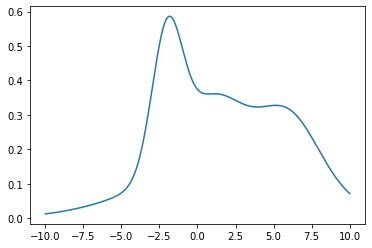

In [8]:
def gauss_with_noise(x, mu=None, sigma=None):
    mu = mu or [0]
    sigma = sigma or [1]
    assert len(mu)==len(sigma), "Mu and sigma should have the same size"
    y = np.zeros_like(x)
    for m,s in zip(mu, sigma):
        y = y + 1/(s*np.sqrt(2*np.pi))*np.exp(-(x-m)**2/(2*s**2))
    return y

n_elem = 10000
x = np.linspace(-10,10,n_elem)
y = gauss_with_noise(x,
#     mu=[-2, 0, 1, 4, 4.5, 6, 9],
    mu=[-2, 0, 1, 3.5, 6],
#     sigma=[2, 5, 0.2, 3, 1, 0.7, 0.2])
    sigma=[1, 5, 2, 5, 2])

x2 = np.linspace(-20,20,n_elem)
y2 = gauss_with_noise(x2,
    mu=[-2, 0, 1, 3.5, 6],
    sigma=[1, 5, 2, 5, 2])

plt.figure()
plt.plot(x,y)
#plt.plot(x2,y2)

Took  0.100 seconds for the training


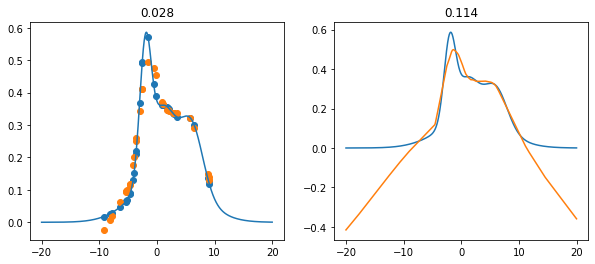

Stopped early at epoch 178
Took  0.729 seconds for the training


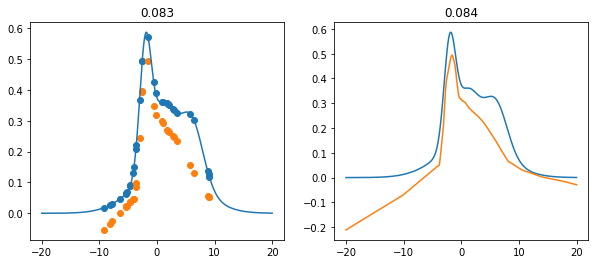

Took  0.001 seconds for the training


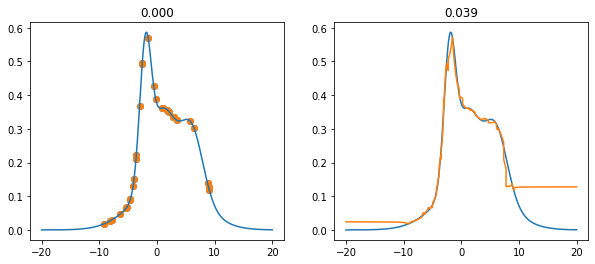

In [26]:
def train_plot_mlp(mlp, x_train, y_train, x_tot, y_tot):
    s = time.time()
    mlp.fit(x_train, y_train)
    e = time.time()
    print(f"Took {e-s:6.3f} seconds for the training")
    y_predict = mlp.predict(x_train)
    loss = np.abs(y_predict-y_train).mean()
    
    y_predict_tot = mlp.predict(x_tot)
    loss_tot = np.abs(y_predict_tot-y_tot).mean()

    train = (x_train, y_train, y_predict, loss)
    test = (x_tot, y_tot, y_predict_tot, loss_tot)
    if x_train.shape[1]==1:
        visualize2d(train, test)
    else:
        visualize3d(train, test)
    plt.show()
    plt.close()


# Select Training data
np.random.seed(0)
n_select = 32
selected = np.arange(0,n_elem)
np.random.shuffle(selected)
selected = selected[:n_select]
x_train = x[selected][:,np.newaxis]
y_train = y[selected]

# Sklearn MLP
mlp = MLPRegressor(
    hidden_layer_sizes=(50,)*4, batch_size=8, learning_rate_init=5e-2, # TODO: adapt the meta-parameters on this line
    solver='sgd', activation='relu', max_iter=500, early_stopping=False, n_iter_no_change=10 # DO NOT change these
)
train_plot_mlp(mlp, x_train, y_train, x2[:,np.newaxis], y2)

# Our MLP
mlp = MyMLPRegressor(
    n_layers=4, hidden_size=50, lr_init=1e-1, batch_size=8, n_epochs=200, early_stopping=100, milestones=[200,300]
)
train_plot_mlp(mlp, x_train, y_train, x2[:,np.newaxis], y2)
               
# KNN
rbfn = KNeighborsRegressor(3, weights="distance")
train_plot_mlp(rbfn, x_train, y_train, x2[:,np.newaxis], y2)


## 3.5 Conlusions about simple Fully-Connected Neural Networks

Benefits:
* Can in *theory* approximate any function
* Handy for feature extraction (see next session)

Drawbacks:
* Really hard to train
* No guarantees on result
* Regularisation is hard, meta-parameter search is really important
* Hard to measure the *expressivity* of a Neural Network
* Hard to understand inner workings

## 3.7 Further reading
Training large neural networks is hard and if you ever want to do it more seriously you'll need to look into more specialized training mechanism:
* SGD w/ momentum: Trains faster
* Adam(W): Trains even faster
* Weight Decay: Avoids explosion of weight's absolute magnitude

As well as research which network structures work for your specific problem:
* LSTM and Transformers: Natural language processing tasks
* ConvNets (ResNets, VGG, DenseNet etc.): Image processing tasks
* Fully connected networks: Any use case not covered by more specific networks (i.e. a vector as input and a vector as output)

Finally you may want to gain some insight into the inner workings of your neural network. There are a lot of great tools with more and more being made by the minute. Never skip this step if you ever want to deploy a NN on a real-life project, you may be unaware of some of its failure cases: NN are bad at extrapolating outside of their domain!


Furthermore this field is exploding in popularity in the last 5-10 years, thus there are a lot of papers out there claiming a lot of stuff. Always keep a healthy dose of scepticism with regards to published results especially whenever the source code may not be available: reproducing a DL-paper is more work than it may originally seem.

# Session is done
The code below is to generate the images

In [6]:
def f(x, add_noise=False):
    a,b,c=1,2,0.5
    if add_noise:
        eps = np.random.normal(0,0.5, x.shape)
    else:
        eps=0
    return (x-a)**2+x*b+c+eps
x = np.linspace(-2,2,1000)
xx = np.random.rand(10)*4-2
yy = f(xx, add_noise=True)

In [7]:
for degree in [2,4,6,9]:
    plt.plot(x,f(x), linestyle="dashed", label="Ground Truth")
    plt.scatter(xx, f(xx))
    plt.scatter(xx, yy, marker="X")
    plt.plot(x, np.poly1d(np.polyfit(xx, yy, degree))(x), )
    plt.ylim([-1,10])
    plt.title(f"Fitting the orange points with an {degree} polynomial")
    #plt.savefig(f"images/int{degree}.png")
    plt.close()